#참고
002. recommender system basic with Python - 1 content based filtering.ipynb
https://github.com/lsjsj92/recommender_system_with_Python/blob/master/002.%20recommender%20system%20basic%20with%20Python%20-%201%20content%20based%20filtering.ipynb

# Import

In [ ]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt


from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances


# 데이터 가져오기



In [ ]:
pip install pymysql

In [ ]:
import pymysql

# 전역변수 선언부
conn = None
cur = None
sql = ""

# 메인 코드
conn = pymysql.connect(host = 'webservice.c7lmmj1i3i2l.ap-northeast-2.rds.amazonaws.com', user = 'hugebird', password='5ab5c87a', db = 'webservice', charset = 'utf8')
cur = conn.cursor()

sql = 'select course_id, avg_speed, ele_dif, distance from course'
cur.execute(sql)  # 커서로 sql문 실행

result = cur.fetchall()


dataframe = pd.DataFrame(result, columns=['gpx_id', 'avg_speed', 'ele_dif', 'distance'])
datas = pd.DataFrame(dataframe, columns = ["avg_speed", "ele_dif", "distance"])
print(datas)


      avg_speed  ele_dif  distance
0          3.51      462     17.47
1          2.67      606     13.23
2          3.80      762      8.60
3          5.05      336     24.38
4          4.43      723     16.72
...         ...      ...       ...
8289       3.46      556      6.73
8290       3.74      649     10.60
8291       3.60      406      6.76
8292       4.27      430     12.64
8293       3.85      589      7.89

[8294 rows x 3 columns]


In [ ]:
sql = 'select record_id, avg_speed, ele_dif, distance, user_id from record'
cur.execute(sql)
result = cur.fetchall()

records = pd.DataFrame(result, columns = ['record_id', 'avg_speed', 'ele_dif', 'distance', 'user_id'])
print(records)

    record_id  avg_speed  ele_dif  distance  user_id
0           1       3.12      511      6.38        0
1           2       3.40      398      6.90        0
2           3       2.90      366     10.06        0
3           4       2.78      424      7.44        0
4           5       2.64      423      6.36        0
..        ...        ...      ...       ...      ...
89         90       2.92      332      7.21        1
90         91       4.34      113      9.12        1
91         92       3.22      543      7.45        1
92         93       2.89      479      6.70        1
93         94       2.96      855     10.75        1

[94 rows x 5 columns]


데이터 정보

In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8294 entries, 0 to 8293
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gpx_id     8294 non-null   int64  
 1   avg_speed  8294 non-null   float64
 2   ele_dif    8294 non-null   int64  
 3   distance   8294 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 259.3 KB


특성 요약 정보

In [ ]:
#dataframe.shape
#dataframe.head(3)
#dataframe.describe()
dataframe

,gpx_id,avg_speed,ele_dif,distance
0,1,3.51,462,17.47
1,2,2.67,606,13.23
2,3,3.80,762,8.60
3,4,5.05,336,24.38
4,5,4.43,723,16.72
...,...,...,...,...
8289,9054,3.46,556,6.73
8290,9056,3.74,649,10.60
8291,9057,3.60,406,6.76
8292,9058,4.27,430,12.64


데이터 상관관계

* 1에 근접: 양의 상관관계
* 0에 근접: 상관관계 없음
* -1에 근접: 음의 상관관계

In [ ]:
corr_matrix = dataframe.corr()
#orr_matrix
#corr_matrix["distance"].sort_values(ascending=False)

## 데이터 시각화


히스토그램

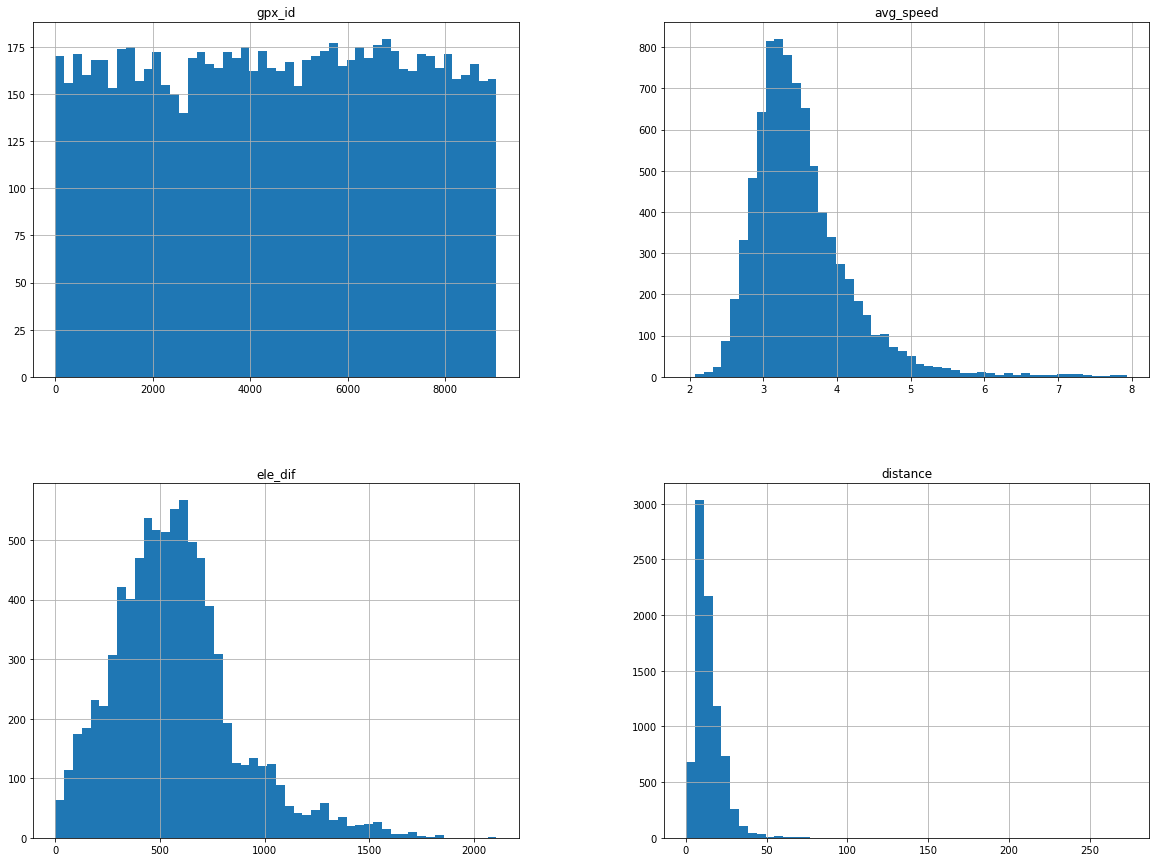

In [ ]:
dataframe.hist(bins=50, figsize=(20, 15))
plt.show()

산점도 행렬

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d784436d0>,
      dtype=object)

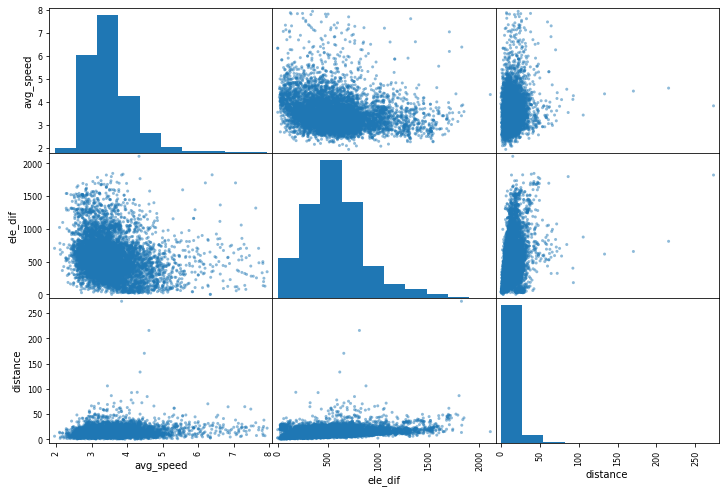

In [ ]:
from pandas.plotting import scatter_matrix
attributes = ["avg_speed", "ele_dif", "distance"]
scatter_matrix(dataframe[attributes], figsize = (12,8))

# 특성 스케일링
1. min-max 스케일링 (정규화 / normalization)
  * 0 ~ 1 밤위에 들도록 값을 이동하고 스케일 조정
  * 데이터에서 최솟값을 뺀 후 최댓값과 최솟값의 차이로 나눔
  * MinMaxScaler
2. 표준화 (standardization)
  * 평균을 뺀 후 표준편차로 나누어 결과 분포의 분산이 1이 되도록 함
  * min-max 스케일링과 달리 표준화는 범위의 상한, 하한이 없음
  * 이상치에 영향을 덜 받음
  * StandardScaler

※ 모든 변환기에서 스케일링은 전체 데이터가 아니라, 훈련 데이터에 대해서만 fit() 메서드 적용

※ 그런 다음 훈련 세트와 테스트 세트에 대해 transform() 메서드 사용

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()
maxAbsScaler = MaxAbsScaler()
robustScaler = RobustScaler()

standardScaler.fit(datas.values)
minMaxScaler.fit(datas.values)
maxAbsScaler.fit(datas.values)
robustScaler.fit(datas.values)

train_data_standardScaled = standardScaler.transform(datas)
train_data_minMaxScaled = minMaxScaler.transform(datas)
train_data_maxAbsScaled = maxAbsScaler.transform(datas)
train_data_robustScaled = robustScaler.transform(datas)

train_data_standardScaled = pd.DataFrame(train_data_standardScaled, index = datas.index, columns = datas.columns)
train_data_minMaxScaled = pd.DataFrame(train_data_minMaxScaled, index = datas.index, columns = datas.columns)
train_data_maxAbsScaled = pd.DataFrame(train_data_maxAbsScaled, index = datas.index, columns = datas.columns)
train_data_robustScaled = pd.DataFrame(train_data_robustScaled, index = datas.index, columns = datas.columns)



print(train_data_standardScaled)
print(train_data_minMaxScaled)
print(train_data_maxAbsScaled)
print(train_data_robustScaled)

      avg_speed   ele_dif  distance
0     -0.001484 -0.373933  0.344010
1     -1.224962  0.117038 -0.104386
2      0.420907  0.648922 -0.594025
3      2.241559 -0.803531  1.074768
4      1.338516  0.515951  0.264695
...         ...       ...       ...
8289  -0.074310 -0.053438 -0.791785
8290   0.333516  0.263647 -0.382518
8291   0.129603 -0.564865 -0.788612
8292   1.105472 -0.483037 -0.166780
8293   0.493733  0.059076 -0.669111

[8294 rows x 3 columns]
      avg_speed   ele_dif  distance
0      0.260434  0.219165  0.062972
1      0.120200  0.287476  0.047439
2      0.308848  0.361480  0.030478
3      0.517529  0.159393  0.088285
4      0.414023  0.342979  0.060224
...         ...       ...       ...
8289   0.252087  0.263757  0.023628
8290   0.298831  0.307875  0.037805
8291   0.275459  0.192600  0.023738
8292   0.387312  0.203985  0.045278
8293   0.317195  0.279412  0.027878

[8294 rows x 3 columns]
      avg_speed   ele_dif  distance
0      0.442065  0.219165  0.063932
1      0.33627

# [그래프 그리기](https://tariat.tistory.com/744)

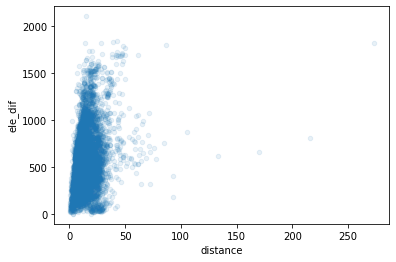

In [ ]:
# sns.relplot(x="distance", y="total_uphill", data=datas)
datas.plot(kind = "scatter", x = "distance", y = "ele_dif", alpha = 0.1)

#[유사도 계산](https://developers.google.com/machine-learning/recommendation/overview/candidate-generation)

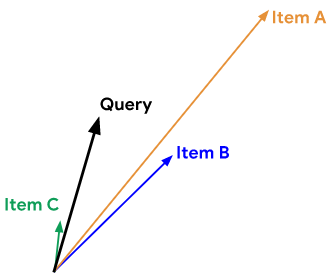
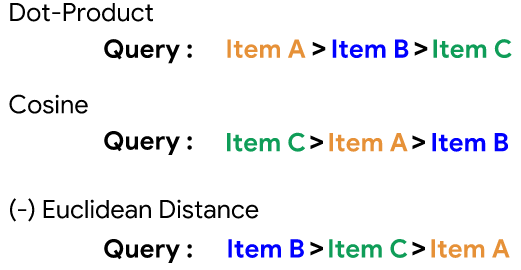

#코사인 유사도
벡터의 크기가 중요한 경우에 대해서 잘 작동하지 않음

In [ ]:
course_similarity_standard =  pd.DataFrame(cosine_similarity(train_data_standardScaled, train_data_standardScaled))
course_similarity_standard.index = train_data_standardScaled.index
course_similarity_standard.columns = train_data_standardScaled.index



course_similarity_minMax =  pd.DataFrame(cosine_similarity(train_data_minMaxScaled, train_data_minMaxScaled))
course_similarity_minMax.index = train_data_minMaxScaled.index
course_similarity_minMax.columns = train_data_minMaxScaled.index



course_similarity_maxAbs =  pd.DataFrame(cosine_similarity(train_data_maxAbsScaled, train_data_maxAbsScaled))
course_similarity_maxAbs.index = train_data_maxAbsScaled.index
course_similarity_maxAbs.columns = train_data_maxAbsScaled.index



course_similarity_robust =  pd.DataFrame(cosine_similarity(train_data_robustScaled, train_data_robustScaled))
course_similarity_robust.index = train_data_robustScaled.index
course_similarity_robust.columns = train_data_robustScaled.index



In [ ]:
print(course_similarity_standard)
print(course_similarity_minMax)
print(course_similarity_maxAbs)
print(course_similarity_robust)


          0         1         2     ...      8291      8292      8293
0     1.000000 -0.124076 -0.903326  ... -0.121186  0.196521 -0.597296
1    -0.124076  1.000000 -0.313548  ... -0.117945 -0.926373 -0.512902
2    -0.903326 -0.313548  1.000000  ...  0.163920  0.211259  0.791638
3     0.502372 -0.914974 -0.084925  ... -0.040353  0.844465  0.156168
4    -0.140126 -0.891979  0.520840  ... -0.228851  0.667770  0.422871
...        ...       ...       ...  ...       ...       ...       ...
8289 -0.622954  0.170088  0.520219  ...  0.826826  0.078004  0.737351
8290 -0.793824 -0.478231  0.965839  ...  0.350119  0.438107  0.914907
8291 -0.121186 -0.117945  0.163920  ...  1.000000  0.459481  0.684293
8292  0.196521 -0.926373  0.211259  ...  0.459481  1.000000  0.619404
8293 -0.597296 -0.512902  0.791638  ...  0.684293  0.619404  1.000000

[8294 rows x 8294 columns]
          0         1         2     ...      8291      8292      8293
0     1.000000  0.891782  0.979740  ...  0.989772  0.974333  0

In [ ]:
gpx_id = 1
course_similarity_standard[gpx_id]

0      -0.124076
1       1.000000
2      -0.313548
3      -0.914974
4      -0.891979
          ...   
8289    0.170088
8290   -0.478231
8291   -0.117945
8292   -0.926373
8293   -0.512902
Name: 1, Length: 8294, dtype: float64

In [ ]:
def get_recommend_course_list(df, gpx_id, scaler, top=30):

    Id = gpx_id
    index = dataframe[dataframe['gpx_id'] == Id].index.values
    new_CBF_standard = np.array(course_similarity_standard)
    new_CBF_minMax = np.array(course_similarity_minMax)
    new_CBF_maxAbs = np.array(course_similarity_maxAbs)
    new_CBF_robust = np.array(course_similarity_robust)
    new_CBF_standard = new_CBF_standard.argsort()[:,::-1]
    new_CBF_minMax = new_CBF_minMax.argsort()[:,::-1]
    new_CBF_maxAbs = new_CBF_maxAbs.argsort()[:,::-1]
    new_CBF_robust = new_CBF_robust.argsort()[:,::-1]

    #코사인 유사도 중 비슷한 코사인 유사도를 가진 정보를 뽑아낸다.
    #     sim_index = new_CBF[index,:].reshape(-1)
    # sim_index = sim_index[sim_index != index]
    # result = movie.iloc[sim_index][:10]    

    if scaler == "standard":
      sim_index = new_CBF_standard[index, :].reshape(-1)
    elif scaler == "minMax":
      sim_index = new_CBF_minMax[index, :].reshape(-1)
    elif scaler == "maxAbs":
      sim_index = new_CBF_maxAbs[index, :].reshape(-1)
    elif scaler == "robust":
      sim_index = new_CBF_robust[index, :].reshape(-1)
      
    #본인을 제외
    sim_index = sim_index[sim_index != index]

    #data frame으로 만들고 vote_count으로 정렬한 뒤 return
   # result = df.iloc[sim_index].sort_values('gpx_id', ascending=False)[:30]
    result = df.iloc[sim_index][:30]
    return result

In [ ]:
# result_standard_group = pd.DataFrame(columns = ["avg_speed", "ele_dif", "distance"])
# result_minMax_group = pd.DataFrame(columns = ["avg_speed", "ele_dif", "distance"])
# result_maxAbs_group = pd.DataFrame(columns = ["avg_speed", "ele_dif", "distance"])
# result_robust_group = pd.DataFrame(columns = ["avg_speed", "ele_dif", "distance"])
# result_euclid_group = pd.DataFrame(columns = ["avg_speed", "ele_dif", "distance"])

In [ ]:
print(result_standard_group)
print(type(result_standard_group))

      avg_speed ele_dif  distance
6211       3.51     465     17.43
8174       3.51     458     17.65
5347       3.50     323     21.23
65         3.50     261     22.87
3022       3.53     376     19.90
...         ...     ...       ...
5567       2.80     727      7.94
2472       3.18     637     11.29
4533       2.83     688      8.56
4893       2.93     711      9.48
1015       2.97     664      9.72

[3000 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>


In [ ]:
idxs = dataframe.head(30)['gpx_id'].values
print(idxs)

[ 1  2  3  4  5  6  7  8  9 10 11 12 14 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32]


In [ ]:
def l1_normalize(v):
  norm = np.sum(v)
  return v / norm

course_l1 = l1_normalize(datas)

euc_similarity_standard =  pd.DataFrame(euclidean_distances(course_l1, course_l1))
euc_similarity_standard.index = datas.index
euc_similarity_standard.columns = datas.index

def get_recommend_course_list_euc(df, gpx_id, scaler, top=30):

    Id = gpx_id
    index = dataframe[dataframe['gpx_id'] == Id].index.values
    new_CBF_standard = np.array(course_similarity_standard)
    new_CBF_standard = new_CBF_standard.argsort()

    if scaler == "standard":
      sim_index = new_CBF_standard[index, :].reshape(-1)
    # #본인을 제외
    sim_index = sim_index[sim_index != index]

    result = df.iloc[sim_index][:30]
    return result



In [ ]:
cos_stan_stds_speed = []
cos_stan_avgs_speed = []
cos_minMax_stds_speed = []
cos_minMax_avgs_speed = []
cos_maxAbs_stds_speed = []
cos_maxAbs_avgs_speed = []
cos_robust_stds_speed = []
cos_robust_avgs_speed = []
euc_stds_speed = []
euc_avgs_speed = []

cos_stan_stds_ele = []
cos_stan_avgs_ele = []
cos_minMax_stds_ele = []
cos_minMax_avgs_ele = []
cos_maxAbs_stds_ele = []
cos_maxAbs_avgs_ele = []
cos_robust_stds_ele = []
cos_robust_avgs_ele = []
euc_stds_ele = []
euc_avgs_ele = []

cos_stan_stds_dis = []
cos_stan_avgs_dis = []
cos_minMax_stds_dis = []
cos_minMax_avgs_dis = []
cos_maxAbs_stds_dis = []
cos_maxAbs_avgs_dis = []
cos_robust_stds_dis = []
cos_robust_avgs_dis = []
euc_stds_dis = []
euc_avgs_dis = []

In [ ]:

for id in idxs:
  print(id)
  recommend_result_standard=get_recommend_course_list(datas, gpx_id= id, scaler = "standard")
  recommend_result_minMax=get_recommend_course_list(datas, gpx_id= id, scaler = "minMax")
  recommend_result_maxAbs=get_recommend_course_list(datas, gpx_id= id, scaler ="maxAbs")
  recommend_result_robust=get_recommend_course_list(datas, gpx_id= id, scaler ="robust")
  recommend_result_euclid=get_recommend_course_list_euc(datas, gpx_id= id, scaler = "standard")

  # result_standard_group = result_standard_group.append(recommend_result_standard )
  # result_minMax_group = result_standard_group.append(recommend_result_minMax )
  # result_maxAbs_group = result_standard_group.append(recommend_result_maxAbs )
  # result_robust_group = result_standard_group.append(recommend_result_robust )
  # result_euclid_group = result_euclid_group.append(recommend_result_euclid)

  # standard
  cos_stan_stds_speed.append(recommend_result_standard.std()['avg_speed'])
  cos_stan_stds_ele.append(recommend_result_standard.std()['ele_dif'])
  cos_stan_stds_dis.append(recommend_result_standard.std()['distance'])
  cos_stan_avgs_speed.append(recommend_result_standard.mean()['avg_speed'])
  cos_stan_avgs_ele.append(recommend_result_standard.mean()['ele_dif'])
  cos_stan_avgs_dis.append(recommend_result_standard.mean()['distance'])

    # minMax
  cos_minMax_stds_speed.append(recommend_result_minMax.std()['avg_speed'])
  cos_minMax_stds_ele.append(recommend_result_minMax.std()['ele_dif'])
  cos_minMax_stds_dis.append(recommend_result_minMax.std()['distance'])
  cos_minMax_avgs_speed.append(recommend_result_minMax.mean()['avg_speed'])
  cos_minMax_avgs_ele.append(recommend_result_minMax.mean()['ele_dif'])
  cos_minMax_avgs_dis.append(recommend_result_minMax.mean()['distance'])

    # maxAbs
  cos_maxAbs_stds_speed.append(recommend_result_maxAbs.std()['avg_speed'])
  cos_maxAbs_stds_ele.append(recommend_result_maxAbs.std()['ele_dif'])
  cos_maxAbs_stds_dis.append(recommend_result_maxAbs.std()['distance'])
  cos_maxAbs_avgs_speed.append(recommend_result_maxAbs.mean()['avg_speed'])
  cos_maxAbs_avgs_ele.append(recommend_result_maxAbs.mean()['ele_dif'])
  cos_maxAbs_avgs_dis.append(recommend_result_maxAbs.mean()['distance'])

    # robust
  cos_robust_stds_speed.append(recommend_result_robust.std()['avg_speed'])
  cos_robust_stds_ele.append(recommend_result_robust.std()['ele_dif'])
  cos_robust_stds_dis.append(recommend_result_robust.std()['distance'])
  cos_robust_avgs_speed.append(recommend_result_robust.mean()['avg_speed'])
  cos_robust_avgs_ele.append(recommend_result_robust.mean()['ele_dif'])
  cos_robust_avgs_dis.append(recommend_result_robust.mean()['distance'])

    # euclid
  euc_stds_speed.append(recommend_result_euclid.std()['avg_speed'])
  euc_stds_ele.append(recommend_result_euclid.std()['ele_dif'])
  euc_stds_dis.append(recommend_result_euclid.std()['distance'])
  euc_avgs_speed.append(recommend_result_euclid.mean()['avg_speed'])
  euc_avgs_ele.append(recommend_result_euclid.mean()['ele_dif'])
  euc_avgs_dis.append(recommend_result_euclid.mean()['distance'])

print(cos_stan_stds_speed)
# print(result_minMax_group)
# print(result_maxAbs_group)
# print(result_robust_group)

1
2
3
4
5
6
7
8
9
10
11
12
14
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
[0.05037331897312126, 0.22708573498677265, 0.07712059521876469, 0.7166489706449293, 0.9735551628810839, 0.26078594736838795, 0.8388887696328352, 1.1037918448609816, 1.0162803486865406, 0.1303822849542263, 0.15762023325396546, 0.07276240661283787, 0.22889665388755587, 0.1161627870854013, 0.6785918482797477, 0.27321500101862856, 0.23534982521745174, 0.17671198724699355, 0.11975837743355262, 0.04513071691426371, 0.18943988826107291, 0.15007316223425327, 0.13519717401657838, 0.10798094765962776, 0.17951435123368428, 0.15790619942260647, 0.10518784510874193, 0.05952397372719556, 0.17600809803731374, 0.6054219579156647]


In [ ]:
print(euc_avgs_dis)
# print(result_minMax_group.describe())
# print(result_maxAbs_group.describe())
# print(result_robust_group.describe())
# print(result_euclid_group.describe())

[9.561666666666667, 16.637333333333334, 20.209666666666667, 8.90066666666667, 12.661333333333335, 9.958666666666664, 12.898666666666667, 11.662333333333333, 10.117333333333335, 5.533333333333332, 24.166999999999998, 23.776, 25.054333333333332, 24.843000000000007, 7.494666666666666, 24.615999999999996, 26.508333333333336, 20.569999999999997, 30.315666666666665, 24.807333333333325, 18.573666666666668, 26.05, 10.014666666666665, 10.086999999999998, 9.229000000000001, 18.270333333333333, 19.907666666666664, 25.40666666666666, 26.171, 16.015333333333334]


In [ ]:
tempdf = pd.DataFrame(result_euclid_group, columns = ["avg_speed", "ele_dif", "distance"])
print(tempdf.mean()['ele_dif'])
tempdf['ele_dif'] = tempdf['ele_dif'].astype('int64')
print(tempdf.dtypes)
print(tempdf.mean()['ele_dif'])
# cat_columns = tempdf.select_dtypes(['category'].columns)
# cat_columns
# Index([u'ele_dif'], dtype = 'object')
# tempdf[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
print(tempdf.describe())


705.1293333333333
avg_speed    float64
ele_dif        int64
distance     float64
dtype: object
705.1293333333333
         avg_speed      ele_dif     distance
count  3000.000000  3000.000000  3000.000000
mean      3.733687   705.129333    17.925997
std       0.761329   358.604298     8.895001
min       1.950000     0.000000     0.790000
25%       3.290000   482.000000    11.187500
50%       3.610000   671.500000    16.385000
75%       4.020000   884.000000    22.640000
max       7.940000  2108.000000    70.450000


In [ ]:
print(recommend_result_standard.describe())
# print(recommend_result_minMax.describe())
# print(recommend_result_maxAbs.describe())
# print(recommend_result_robust.describe())

       avg_speed     ele_dif   distance
count  30.000000   30.000000  30.000000
mean    2.869000  698.133333   9.299667
std     0.221567   43.461226   1.699096
min     2.480000  597.000000   6.300000
25%     2.692500  672.000000   8.482500
50%     2.845000  702.000000   8.860000
75%     2.977500  729.250000  10.080000
max     3.400000  770.000000  13.280000


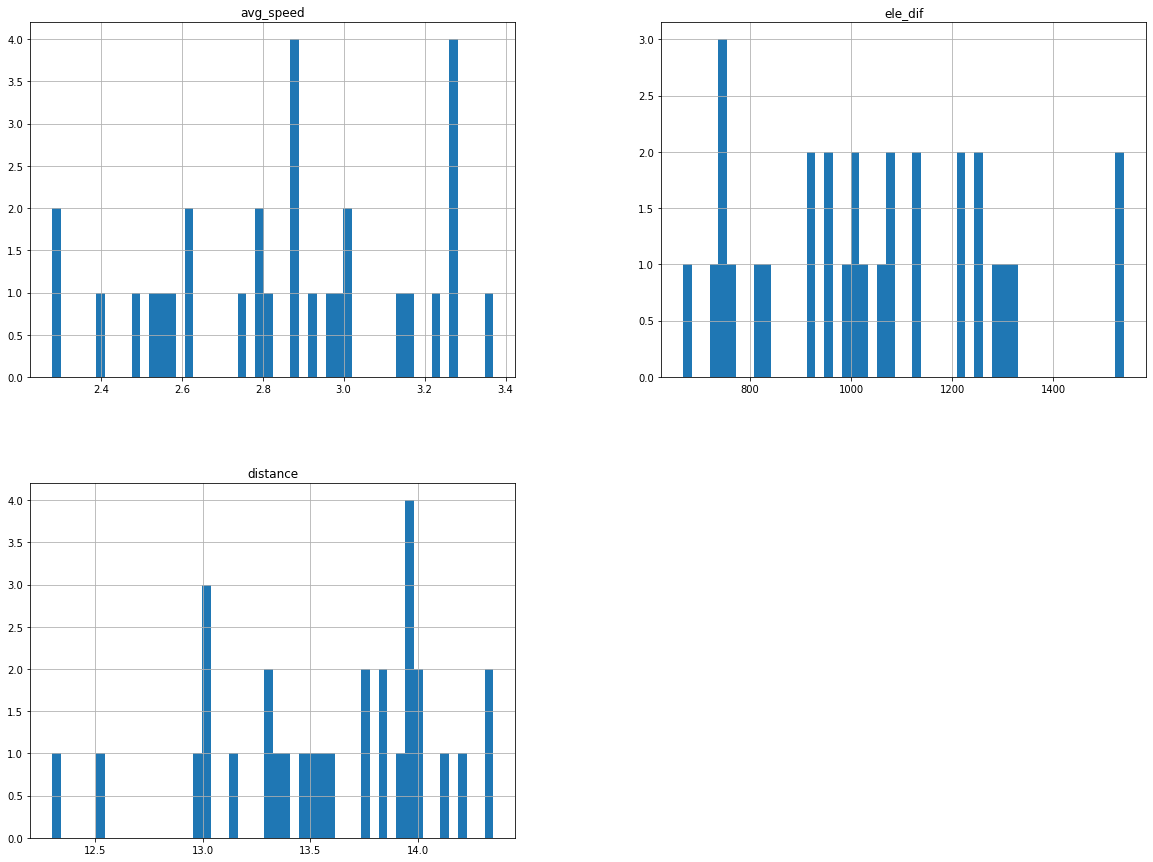

In [ ]:
recommend_result_standard.hist(bins=50, figsize=(20, 15))
# recommend_result_minMax.hist(bins=50, figsize=(20, 15))
# recommend_result_maxAbs.hist(bins=50, figsize=(20, 15))
# recommend_result_robust.hist(bins=50, figsize=(20, 15))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd9f765990>,
      dtype=object)

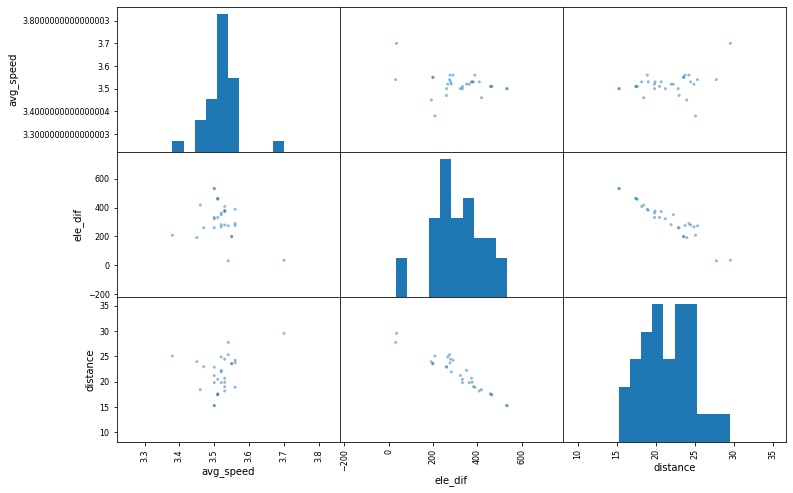

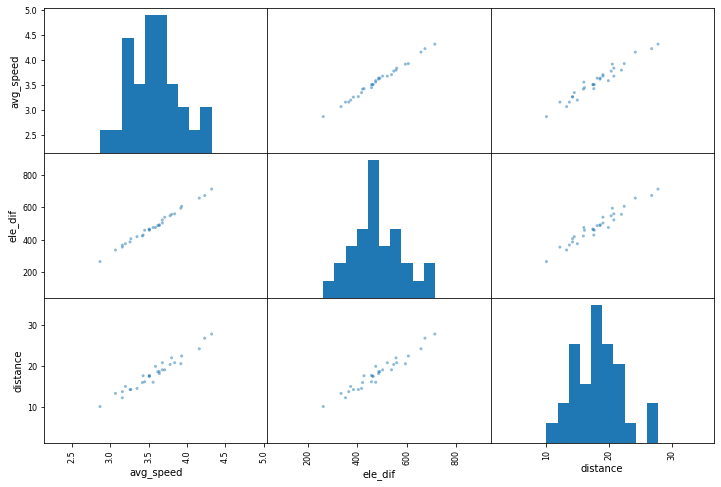

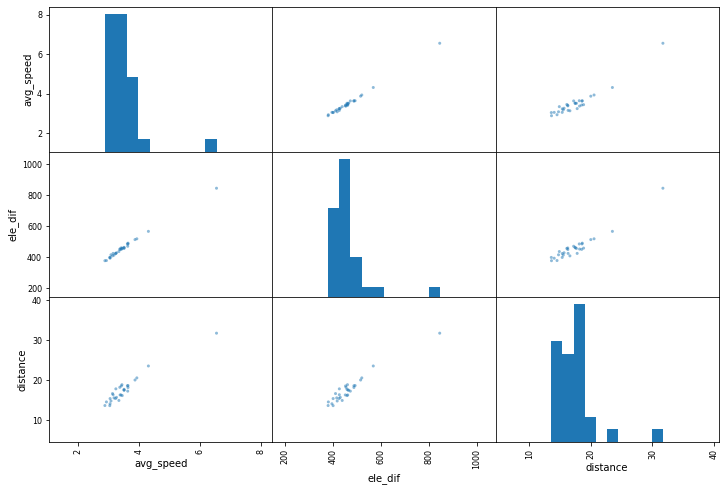

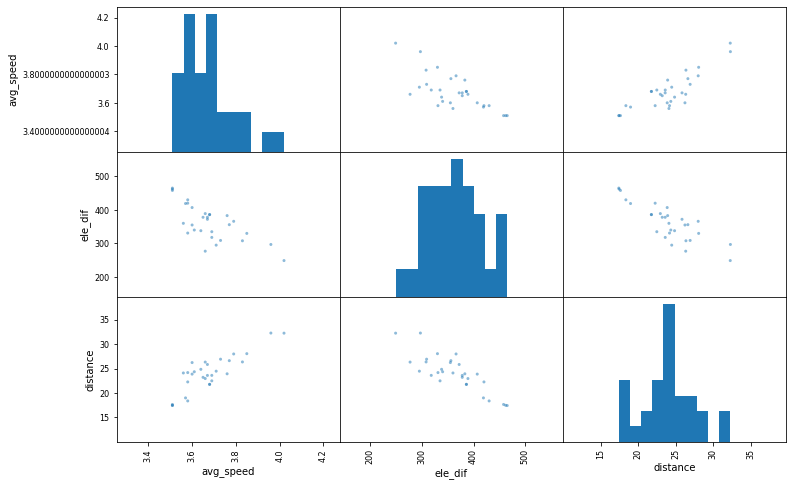

In [ ]:
from pandas.plotting import scatter_matrix
attributes = ["avg_speed", "ele_dif", "distance"]
scatter_matrix(recommend_result_standard[attributes], alpha=0.5, range_padding = 1, figsize = (12,8))
attributes = ["avg_speed", "ele_dif", "distance"]
scatter_matrix(recommend_result_minMax[attributes], alpha=0.5, range_padding = 1, figsize = (12,8))
attributes = ["avg_speed", "ele_dif", "distance"]
scatter_matrix(recommend_result_maxAbs[attributes], alpha=0.5, range_padding = 1, figsize = (12,8))
attributes = ["avg_speed", "ele_dif", "distance"]
scatter_matrix(recommend_result_robust[attributes], alpha=0.5, range_padding = 1,  figsize = (12,8))

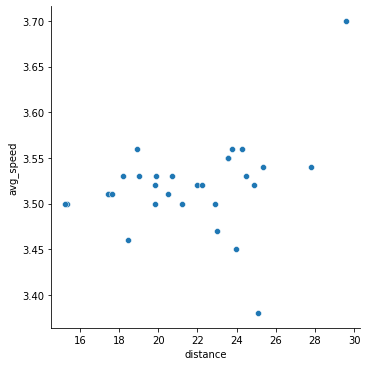

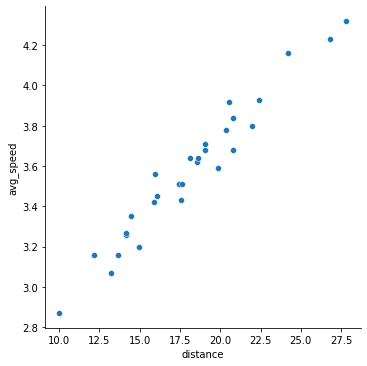

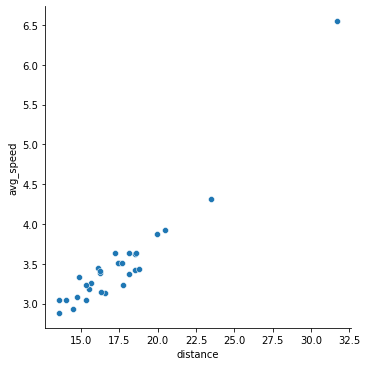

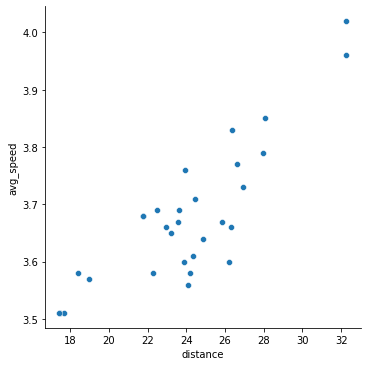

In [ ]:
sns.relplot(x="distance", y="avg_speed", data=recommend_result_standard)
sns.relplot(x="distance", y="avg_speed", data=recommend_result_minMax)
sns.relplot(x="distance", y="avg_speed", data=recommend_result_maxAbs)
sns.relplot(x="distance", y="avg_speed", data=recommend_result_robust)

#유클리드 거리
https://lsjsj92.tistory.com/443

앞서서 봤던 유사도들은 값이 0 ~ 1 또는 -1 ~ 1 사이와 같이 법위가 정해져있는데, 유클리디안은 값의 범위가 정해져있지 않습니다.

왜냐하면 거리이기 때문에 그렇습니다.

그래서 머신러닝이나 딥러닝을 할 때는 L1 정규화를 사용합니다.

L1 정규화 (L1 normalize)는 각 벡터 안의 요소 값을 모두 더한 것이 크기가 1이 되도록 벡터들의 크기를 조절하는 방법입니다.


In [ ]:
def l1_normalize(v):
  norm = np.sum(v)
  return v / norm

course_l1 = l1_normalize(datas)

euc_similarity_standard =  pd.DataFrame(euclidean_distances(course_l1, course_l1))
euc_similarity_standard.index = datas.index
euc_similarity_standard.columns = datas.index

def get_recommend_course_list_euc(df, gpx_id, scaler, top=30):

    Id = gpx_id
    index = dataframe[dataframe['gpx_id'] == Id].index.values
    new_CBF_standard = np.array(course_similarity_standard)
    new_CBF_standard = new_CBF_standard.argsort()

    if scaler == "standard":
      sim_index = new_CBF_standard[index, :].reshape(-1)
    # #본인을 제외
    sim_index = sim_index[sim_index != index]

    result = df.iloc[sim_index][:30]
    return result

euc_result=get_recommend_course_list_euc(datas, gpx_id= 2, scaler = "standard")

In [ ]:
def l1_normalize(v):
  norm = np.sum(v)
  return v / norm

course_l1 = l1_normalize(datas)

In [ ]:
# course_similarity_standard = euclidean_distances(train_data_standardScaled, train_data_standardScaled).argsort()[:, ::-1]
# course_similarity_minMax = euclidean_distances(train_data_minMaxScaled, train_data_minMaxScaled).argsort()[:, ::-1]
# course_similarity_maxAbs = euclidean_distances(train_data_maxAbsScaled, train_data_maxAbsScaled).argsort()[:, ::-1]
# course_similarity_robust = euclidean_distances(train_data_robustScaled, train_data_robustScaled).argsort()[:, ::-1]
print(course_l1)

      avg_speed   ele_dif  distance
0      0.000121  0.000097  0.000148
1      0.000092  0.000128  0.000112
2      0.000130  0.000161  0.000073
3      0.000173  0.000071  0.000207
4      0.000152  0.000152  0.000142
...         ...       ...       ...
8289   0.000119  0.000117  0.000057
8290   0.000128  0.000137  0.000090
8291   0.000124  0.000086  0.000057
8292   0.000147  0.000091  0.000107
8293   0.000132  0.000124  0.000067

[8294 rows x 3 columns]


In [ ]:
euc_similarity_standard =  pd.DataFrame(euclidean_distances(course_l1, course_l1))
euc_similarity_standard.index = datas.index
euc_similarity_standard.columns = datas.index

# course_similarity_minMax =  pd.DataFrame(euclidean_distances(train_data_minMaxScaled, train_data_minMaxScaled))
# course_similarity_minMax.index = train_data_minMaxScaled.index
# course_similarity_minMax.columns = train_data_minMaxScaled.index

# course_similarity_maxAbs =  pd.DataFrame(euclidean_distances(train_data_maxAbsScaled, train_data_maxAbsScaled))
# course_similarity_maxAbs.index = train_data_maxAbsScaled.index
# course_similarity_maxAbs.columns = train_data_maxAbsScaled.index

# course_similarity_robust =  pd.DataFrame(euclidean_distances(train_data_robustScaled, train_data_robustScaled))
# course_similarity_robust.index = train_data_robustScaled.index
# course_similarity_robust.columns = train_data_robustScaled.index
print(euc_similarity_standard)

          0         1         2     ...          8291      8292      8293
0     0.000000  0.000055  0.000099  ...  9.164392e-05  0.000049  0.000086
1     0.000055  0.000000  0.000064  ...  7.622225e-05  0.000066  0.000061
2     0.000099  0.000064  0.000000  ...  7.699369e-05  0.000080  0.000037
3     0.000083  0.000137  0.000167  ...  1.581962e-04  0.000105  0.000155
4     0.000064  0.000072  0.000073  ...  1.114310e-04  0.000071  0.000082
...        ...       ...       ...  ...           ...       ...       ...
8289  0.000093  0.000062  0.000048  ...  3.200007e-05  0.000063  0.000018
8290  0.000071  0.000044  0.000029  ...  6.091134e-05  0.000053  0.000027
8291  0.000092  0.000076  0.000077  ...  2.572439e-12  0.000055  0.000041
8292  0.000049  0.000066  0.000080  ...  5.515062e-05  0.000000  0.000054
8293  0.000086  0.000061  0.000037  ...  4.068376e-05  0.000054  0.000000

[8294 rows x 8294 columns]


In [ ]:

print(euc_similarity_standard)
# print(course_similarity_minMax)
# print(course_similarity_maxAbs)
# print(course_similarity_robust)


          0         1         2     ...          8291      8292      8293
0     0.000000  0.000055  0.000099  ...  9.164392e-05  0.000049  0.000086
1     0.000055  0.000000  0.000064  ...  7.622225e-05  0.000066  0.000061
2     0.000099  0.000064  0.000000  ...  7.699369e-05  0.000080  0.000037
3     0.000083  0.000137  0.000167  ...  1.581962e-04  0.000105  0.000155
4     0.000064  0.000072  0.000073  ...  1.114310e-04  0.000071  0.000082
...        ...       ...       ...  ...           ...       ...       ...
8289  0.000093  0.000062  0.000048  ...  3.200007e-05  0.000063  0.000018
8290  0.000071  0.000044  0.000029  ...  6.091134e-05  0.000053  0.000027
8291  0.000092  0.000076  0.000077  ...  2.572439e-12  0.000055  0.000041
8292  0.000049  0.000066  0.000080  ...  5.515062e-05  0.000000  0.000054
8293  0.000086  0.000061  0.000037  ...  4.068376e-05  0.000054  0.000000

[8294 rows x 8294 columns]


In [ ]:
# recommend_result_standard=get_recommend_course_list(datas, gpx_id=100, scaler = "standard")
# recommend_result_minMax=get_recommend_course_list(datas, gpx_id=100, scaler = "minMax")
# recommend_result_maxAbs=get_recommend_course_list(datas, gpx_id=100, scaler ="maxAbs")
# recommend_result_robust=get_recommend_course_list(datas, gpx_id=100, scaler ="robust")

# print(recommend_result_standard)
# print(recommend_result_minMax)
# print(recommend_result_maxAbs)
# print(recommend_result_robust)

In [ ]:
def get_recommend_course_list_euc(df, gpx_id, scaler, top=30):

    Id = gpx_id
    index = dataframe[dataframe['gpx_id'] == Id].index.values
    new_CBF_standard = np.array(course_similarity_standard)
    new_CBF_standard = new_CBF_standard.argsort()

    if scaler == "standard":
      sim_index = new_CBF_standard[index, :].reshape(-1)
    # #본인을 제외
    sim_index = sim_index[sim_index != index]

    result = df.iloc[sim_index][:30]
    return result

In [ ]:
euc_result=get_recommend_course_list_euc(datas, gpx_id= 2, scaler = "standard")
# recommend_result_minMax=get_recommend_course_list(datas, gpx_id= 5752, scaler = "minMax")
# recommend_result_maxAbs=get_recommend_course_list(datas, gpx_id= 5752, scaler ="maxAbs")
# recommend_result_robust=get_recommend_course_list(datas, gpx_id= 5752, scaler ="robust")

print(euc_result)
# print(recommend_result_minMax)
# print(recommend_result_maxAbs)
# print(recommend_result_robust)

      avg_speed  ele_dif  distance
405        4.89      521     16.30
5989       6.77      429     19.30
4433       3.98      552     15.00
2730       7.80      329     17.65
8046       4.64      547     15.73
6250       5.76      438     16.19
1026       7.94      345     22.41
4365       4.33      555     15.46
4592       7.14      354     20.19
8203       4.10      560     15.15
7680       4.63      498     15.46
8206       4.70      493     15.38
499        7.14      524     17.19
1781       4.43      510     14.78
7521       7.82      499     22.11
2810       3.75      557     14.31
5781       4.43      537     16.30
4244       6.05      517     14.91
7320       4.65      489     14.97
7992       6.19      399     14.89
6092       5.45      447     14.64
7522       6.83      561     17.39
5988       4.95      476     14.50
1788       7.71      482     23.86
4434       6.50      564     16.69
3446       5.34      482     13.88
1090       6.02      502     20.52
7024       5.19     

In [ ]:
print(euc_result.describe())

       avg_speed     ele_dif   distance
count  30.000000   30.000000  30.000000
mean    3.496667  739.733333   9.561667
std     0.052083   50.117746   1.180623
min     3.410000  655.000000   6.530000
25%     3.462500  715.000000   8.940000
50%     3.490000  734.500000   9.760000
75%     3.532500  769.000000  10.190000
max     3.620000  909.000000  11.260000


In [ ]:
id = 363

recommend_result_standard=get_recommend_course_list(datas, gpx_id= id, scaler = "standard")
recommend_result_minMax=get_recommend_course_list(datas, gpx_id= id, scaler = "minMax")
recommend_result_maxAbs=get_recommend_course_list(datas, gpx_id= id, scaler ="maxAbs")
recommend_result_robust=get_recommend_course_list(datas, gpx_id= id, scaler ="robust")
euc_result=get_recommend_course_list_euc(datas, gpx_id= id, scaler = "standard")

In [ ]:
print(recommend_result_standard.describe())
print(recommend_result_minMax.describe())
print(recommend_result_maxAbs.describe())
print(recommend_result_robust.describe())
print(euc_result.describe())

       avg_speed     ele_dif    distance
count  30.000000   30.000000   30.000000
mean    3.848667  627.300000   55.388333
std     0.303880   54.751571   45.219299
min     3.550000  569.000000   19.310000
25%     3.630000  591.250000   27.825000
50%     3.750000  614.500000   37.505000
75%     3.887500  647.750000   62.995000
max     4.610000  810.000000  215.560000
       avg_speed     ele_dif   distance
count  30.000000   30.000000  30.000000
mean    3.404000  484.966667  43.298667
std     0.466007  148.631570  18.061227
min     2.490000  171.000000  12.590000
25%     3.017500  360.000000  27.432500
50%     3.340000  490.000000  43.185000
75%     3.800000  607.000000  56.262500
max     4.560000  761.000000  84.810000
       avg_speed     ele_dif   distance
count  30.000000   30.000000  30.000000
mean    3.629000  613.000000  55.864667
std     0.462999   89.922189  12.114092
min     2.860000  479.000000  35.630000
25%     3.307500  550.250000  45.605000
50%     3.620000  597.000000  5

In [ ]:
from pandas.plotting import scatter_matrix
attributes = ["avg_speed", "ele_dif", "distance"]
scatter_matrix(recommend_result_standard[attributes], alpha=0.5, range_padding = 1, figsize = (12,8))
# attributes = ["avg_speed", "ele_dif", "distance"]
# scatter_matrix(recommend_result_minMax[attributes], alpha=0.5, range_padding = 1, figsize = (12,8))
# attributes = ["avg_speed", "ele_dif", "distance"]
# scatter_matrix(recommend_result_maxAbs[attributes], alpha=0.5, range_padding = 1, figsize = (12,8))
# attributes = ["avg_speed", "ele_dif", "distance"]
# scatter_matrix(recommend_result_robust[attributes], alpha=0.5, range_padding = 1,  figsize = (12,8))

In [ ]:
sns.relplot(x="distance", y="avg_speed", data=recommend_result_standard)
sns.relplot(x="distance", y="avg_speed", data=recommend_result_minMax)
sns.relplot(x="distance", y="avg_speed", data=recommend_result_maxAbs)
sns.relplot(x="distance", y="avg_speed", data=recommend_result_robust)

# 결과


In [ ]:
print(recommend_result_standard.describe())
print(recommend_result_minMax.describe())
print(recommend_result_maxAbs.describe())
print(recommend_result_robust.describe())
print(euc_result.describe())

       avg_speed     ele_dif  distance
count    30.0000   30.000000  30.00000
mean      2.8440  603.466667  13.22700
std       0.2214   21.704494   0.59116
min       2.5000  558.000000  12.19000
25%       2.6625  590.000000  12.85500
50%       2.8350  600.000000  13.03500
75%       3.0500  618.250000  13.55000
max       3.2700  648.000000  14.57000
       avg_speed      ele_dif   distance
count  30.000000    30.000000  30.000000
mean    2.993333   874.533333  18.710667
std     0.308124   259.728205   5.378351
min     2.590000   571.000000  12.190000
25%     2.750000   674.250000  15.252500
50%     2.930000   815.000000  16.390000
75%     3.110000   962.500000  21.477500
max     3.760000  1570.000000  34.010000
       avg_speed     ele_dif   distance
count  30.000000   30.000000  30.000000
mean    3.215333  732.800000  15.800333
std     0.416635   98.360491   2.119889
min     2.600000  595.000000  13.230000
25%     2.995000  685.500000  14.490000
50%     3.105000  711.000000  15.380000


#[K-means와 DBSCAN 비교](https://neocarus.tistory.com/entry/K-means%EC%99%80-DBSCAN-%EB%B9%84%EA%B5%90)

###K-means clustering
*   K개 군집의 중심좌표를 고려하여 각 객체를 가까운 군집에 배정하는 반복적 알고리즘
*   군집의 개수(K)오 초기 중심점에 따라서 결과가 달라짐
*   이상치가 전체 거리 평균값에 영향을 주어 이상치에 민감한 단점이 있음
*   이를 개선하기 위해 평균 대신 중간점(medoids)을 사용하는 K-medoids clustering 방법이 있음

###DBSCAN (Density-Based Spatial Clustering of Applications with Noise)


*   eps-neighbors와 minPts를 사용하여 군집을 구성
 -  Eps-neighbors: 한 데이터를 중심으로 epsilone 거리 이내의 데이터들을 한 군집으로 구성
  -  minPts: 한 군집은 minPts 보다 많거나 같은 수의 데이터로 구성됨. 만약 minPts보다 적은 수의 데이터가 eps-neighbors를 형성하면 노이즈(noise)로 취급함
*   k-means와 다르게 군집의 수를 설정할 필요가 없음
*   다양한 모양의 군집이 형성될 수 있으며, 군집끼리 겹치는 경우가 없음
*   노이즈 개념 덕분에 이상치에 대응이 가능


#[콘텐츠 기반 필터링 장점 및 단점](https://developers.google.com/machine-learning/recommendation/content-based/summary)



*   장점
 - 권장 사항은이 사용자에게 고유하므로 모델에는 다른 사용자에 대한 데이터가 필요하지 않습니다. 이렇게하면 많은 사용자로 쉽게 확장 할 수 있습니다.
 - 이 모델은 사용자의 특정 관심사를 포착 할 수 있으며 다른 사용자가 거의 관심을 갖지 않는 틈새 항목을 추천 할 수 있습니다.
*   단점
 - 항목의 기능 표현은 어느 정도 수작업으로 제작되었으므로이 기술에는 많은 도메인 지식이 필요합니다. 따라서 모델은 수작업으로 제작 된 기능만큼 우수 할 수 있습니다.
 - 
모델은 사용자의 기존 관심사를 기반으로 만 추천 할 수 있습니다. 즉,이 모델은 사용자의 기존 관심사를 확장하는 능력이 제한되어 있습니다.







